<a href="https://colab.research.google.com/github/martinaturchini/HIV-1-cleavage-project/blob/main/HIV_CLEAVAGE_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HIV-1 Cleavage Prediction

This work shows the possibility to study and predict the HIV-1 cleavage sites given the combination of sequence information, including amino acid binary profiles, bond composition, and physicochemical properties. The best performances are obtained via the Multi-Layer Perceptron classifier and similar results can be obtained with the Logistic Regression classifier. The k-NN classifier is the worst among the methods analyzed in this work.
The results could be improved by using a larger data set, that can be implemented via data augmentation techniques.


To work with the code is necessary to download and save the data set (https://github.com/martinaturchini/HIV-1-cleavege-/blob/main/12859_2022_5017_MOESM2_ESM.xlsx) in "/content/gdrive/My Drive".

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Optimizer, Adam
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from itertools import product

In [3]:
# Import a function from a .py file located on GitHub into the main Jupyter Notebook on Google Colab
!git clone https://github.com/martinaturchini/HIV-1-cleavage-project.git

# Navigate to the directory where the .py files are located
%cd /content/HIV-1-cleavage-project/source/

Cloning into 'HIV-1-cleavage-project'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 364 (delta 144), reused 186 (delta 115), pack-reused 127 (from 1)
Receiving objects: 100% (364/364), 5.69 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (201/201), done.
/content/HIV-1-cleavage-project/source


In [4]:
from separate import separate
from plot_confusion_matrix import plot_confusion_matrix
from evaluate import evaluate
from plot_metrics import plot_metrics
from plot_history import plot_history
from build_model import build_model
from compare_roccurves import compare_roccurves

In [6]:
# Upload the data set into a dataframe
file_dir = '/content/gdrive/My Drive'

df_original = pd.read_excel(f"{file_dir}/12859_2022_5017_MOESM2_ESM.xlsx")

The data set is composed of 5848 octapeptides, of which 1001 are cleaved and 4847 are non-
cleaved. In every octapeptide, the cleavage site is always located between
the fourth and the fifth amino acids. Each octapeptide (octamer) is
composed of 8 amino acids in sequence (e.g. AECFRIFD). There are 20 different possible amino
acids that can be used to form an octapeptide, so there is a total of 20^8 = 2.56 × 10^10 possible combinations, but not every combination is present in the polyproteins produced by the HIV genome.
In the data set, each octamer is represented through a 178-dimension feature vector.

The target vector is a binary variable, assuming the value of 1 for cleaved sequences and
0 for non-cleaved sequences.

In [7]:
# Display the data set

df=df_original
display(df)
df = df.iloc[:,1:]

,octamer,A1,C1,D1,E1,F1,G1,H1,I1,K1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
0,AECFRIFD,1,0,0,0,0,0,0,0,0,...,0.250,0.000,0.250,0.250,0.125,0.625,0.625,0.125,0.125,1
1,HLVEALYL,0,0,0,0,0,0,1,0,0,...,0.625,0.000,0.125,0.125,0.125,0.750,0.625,0.125,0.000,1
2,TQIMFETF,0,0,0,0,0,0,0,0,0,...,0.125,0.000,0.250,0.125,0.000,0.875,0.750,0.000,0.125,1
3,AEELAEIF,1,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.375,0.000,0.625,0.625,0.000,0.000,1
4,PFIFEEEP,0,0,0,0,0,0,0,0,0,...,0.375,0.250,0.250,0.375,0.000,0.625,0.625,0.250,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,YVPVTTFK,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.000,0.125,0.875,0.750,0.250,0.000,0
5844,YVQQHGGV,0,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.000,0.125,0.875,0.250,0.125,0.000,0
5845,YVSNIDGT,0,0,0,0,0,0,0,0,0,...,0.375,0.000,0.125,0.125,0.000,0.875,0.375,0.125,0.000,0
5846,YWPQEAGE,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.250,0.000,0.750,0.375,0.125,0.000,0


#Data Pre-processing

Number of non-cleaved sequences: 4847
Number of cleaved sequences: 1001
The data set is imbalanced


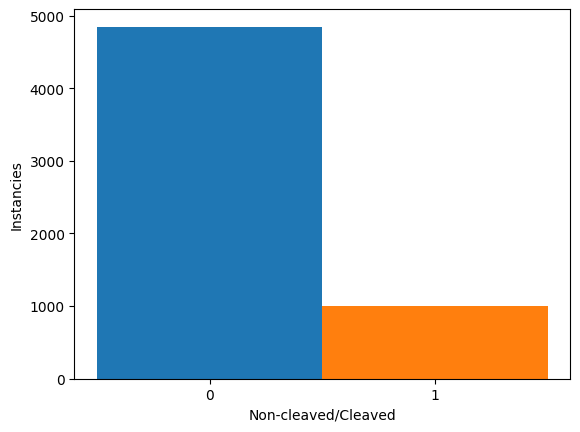

In [8]:
# Show the data distribution divided between non-cleaved sequences (0) and
# cleaved sequences (1) in a histogram.

num_cleaved = df['cleavage Status'][df['cleavage Status'] == 1].count()
num_noncleaved = df['cleavage Status'][df['cleavage Status'] == 0].count()

df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print(f'Number of non-cleaved sequences: {num_noncleaved}')
print(f'Number of cleaved sequences: {num_cleaved}')

if num_noncleaved != num_cleaved:
  print(f'The data set is imbalanced')

Since the features are measured at very different scales, they do not contribute equally to the model
fitting and they might end up creating a bias towards a specific range. The features were scaled with
MinMaxScaler() because it works best when the data distribution is not gaussian, like the Amino Acid Binary Profile (AABP).

In [9]:
# Scikit-learn requires inputs to be in Numpy array format
# Convert them using the function to_numpy()

df_X = df[df.columns[:178]]
df_y = df[df.columns[-1]]

X = df_X.to_numpy()
y = df_y.to_numpy()

X = MinMaxScaler().fit_transform(X)

In [10]:
# Split the data set in 3 subsets: training, test and validation to prevent
# the model from over-fitting and to evaluate it effectively.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, shuffle=True, random_state=42,
    stratify=y_test)

The data set is heavily imbalanced: the non-cleaved octamers (0) far outweigh
the cleaved ones (1). Balancing the dataset is important to prevent the model from being biased towards
one class.

In [11]:
train_df = pd.DataFrame(X_train, columns = df_X.columns)
train_df['cleavage Status'] = y_train

cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 1]

# Cleaved entries (minority class) are 851 in the train set.
# Take 851 entries from the non-cleaved sequence to match the cleaved ones
# using a random undersampling method
non_cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 0].sample(
    n=851, random_state=42)

# Concatenate both dataframes again
equalized_train_df = pd.concat([non_cleaved_train_df, cleaved_train_df])

display(equalized_train_df)

,A1,C1,D1,E1,F1,G1,H1,I1,K1,L1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
1071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.375,0.428571,0.000000,0
3219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.00,0.25,0.000,0.000000,1.000,0.375,0.000000,0.000000,0
3272,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750,0.00,0.00,0.125,0.000000,0.875,0.500,0.000000,0.000000,0
2716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.625,0.00,0.25,0.125,0.000000,0.875,0.375,0.000000,0.000000,0
3033,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.125,0.428571,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.625,0.25,0.00,0.000,0.000000,1.000,0.875,0.142857,0.333333,1
4953,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.125,0.00,0.25,0.125,0.166667,0.750,0.375,0.285714,0.000000,1
4959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250,0.25,0.00,0.250,0.000000,0.750,0.375,0.142857,0.333333,1
4961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.25,0.00,0.250,0.166667,0.625,0.625,0.285714,0.000000,1


Number of non-cleaved sequences in the training set: 851
Number of cleaved sequences in the training set: 851
Now the training set is balanced
Number of non-cleaved sequences in the validation set: 240
Number of cleaved sequences in the validation set: 50
Number of non-cleaved sequences in the test set: 488
Number of cleaved sequences in the test set: 100


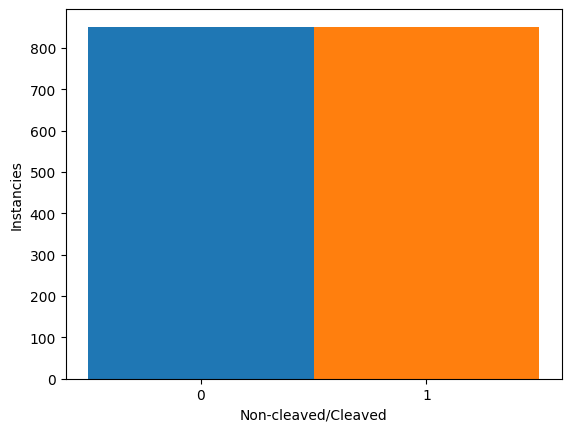

In [12]:
# Show the instances for each class (test, training, validation)

num_cleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 1].count()
num_noncleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 0].count()

equalized_train_df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print(f'Number of non-cleaved sequences in the training set: {num_noncleaved_eq}')
print(f'Number of cleaved sequences in the training set: {num_cleaved_eq}')
print(f'Now the training set is balanced')

print(f'Number of non-cleaved sequences in the validation set: {np.count_nonzero(y_val==0)}')
print(f'Number of cleaved sequences in the validation set: {np.count_nonzero(y_val==1)}')

print(f'Number of non-cleaved sequences in the test set: {np.count_nonzero(y_test==0)}')
print(f'Number of cleaved sequences in the test set: {np.count_nonzero(y_test==1)}')

In [13]:
X_train = equalized_train_df[equalized_train_df.columns[:178]].to_numpy()
y_train = equalized_train_df[equalized_train_df.columns[-1]].to_numpy()

#Method 1: Dense Neural Network (DNN)

##Hyperparameter optimization

In [14]:
class HistoryEpoch(Callback):
  """For saving the accuracy and loss values obtained at the end of each epoch
     during the training.
  """

  def __init__(self, data):
        self.data = data

  def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

The GridSearchCV method, from the Scikit-learn’s model selection package, was used for the hyperparameter tuning.

In [15]:
# Define the grid search parameters
param_space = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01], #l2_lambda
    'learning_rate_init': [0.001, 0.0001],
    'batch_size' : [60, 64, 70],
    'max_iter' : [30, 35, 40] #epochs
}

# Initialize the model
model = MLPClassifier(random_state=1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_space, n_jobs=-1, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {grid_search.best_score_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best hyperparameters: {'alpha': 0.01, 'batch_size': 64, 'learning_rate_init': 0.001, 'max_iter': 30, 'solver': 'adam'}
Best score: 0.9059910298430223


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


I tried some different combinations of dropout and dense nodes, with the goal of finding the ones with the highest accuracy.

In [16]:
param_space_layers = {
    'dropout': [0, 0.2, 0.4],
    'dense_nodes': [[8],[16],[32],[64],[128],
                    [8,4],[16,8],[32,16],[64,32]]
}

# Create all the possible combinations
value_combis = product(*[v for v in param_space_layers.values()])
param_combis = [{key:value for key, value in zip(param_space_layers.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)

We have a total of 27 combinations:
[{'dropout': 0, 'dense_nodes': [8]}, {'dropout': 0, 'dense_nodes': [16]}, {'dropout': 0, 'dense_nodes': [32]}, {'dropout': 0, 'dense_nodes': [64]}, {'dropout': 0, 'dense_nodes': [128]}, {'dropout': 0, 'dense_nodes': [8, 4]}, {'dropout': 0, 'dense_nodes': [16, 8]}, {'dropout': 0, 'dense_nodes': [32, 16]}, {'dropout': 0, 'dense_nodes': [64, 32]}, {'dropout': 0.2, 'dense_nodes': [8]}, {'dropout': 0.2, 'dense_nodes': [16]}, {'dropout': 0.2, 'dense_nodes': [32]}, {'dropout': 0.2, 'dense_nodes': [64]}, {'dropout': 0.2, 'dense_nodes': [128]}, {'dropout': 0.2, 'dense_nodes': [8, 4]}, {'dropout': 0.2, 'dense_nodes': [16, 8]}, {'dropout': 0.2, 'dense_nodes': [32, 16]}, {'dropout': 0.2, 'dense_nodes': [64, 32]}, {'dropout': 0.4, 'dense_nodes': [8]}, {'dropout': 0.4, 'dense_nodes': [16]}, {'dropout': 0.4, 'dense_nodes': [32]}, {'dropout': 0.4, 'dense_nodes': [64]}, {'dropout': 0.4, 'dense_nodes': [128]}, {'dropout': 0.4, 'dense_nodes': [8, 4]}, {'dropout': 0.4, 

In [17]:
# Compile a model for each combination
for idx, params in enumerate(param_combis):
    print(f"Start run {idx + 1}/{len(param_combis)}: Parameters: {params}")

    model = build_model(X_train[0].shape, params, best_params)

    # Construct file path for checkpointing
    param_str = '_'.join([f"{key}={value}" for key, value in params.items()])
    filepath = f"paramsearch_filters_{param_str}.keras"

    # Setup ModelCheckpoint callback
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)

    # Train model
    fit_results = model.fit(
        X_train, y_train,
        batch_size=best_params['batch_size'],
        epochs=best_params['max_iter'],
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, HistoryEpoch((X_train, y_train))],
        verbose=0
    )

    # Extract and store the best validation scores
    best_val_epoch = np.argmax(fit_results.history['val_accuracy'])
    search_results.append({
        **params,
        'train_acc_at_best_val_acc': fit_results.history['accuracy'][best_val_epoch],
        'best_val_acc': fit_results.history['val_accuracy'][best_val_epoch],
        'train_loss_at_best_val_acc': fit_results.history['loss'][best_val_epoch],
        'best_val_acc_loss': fit_results.history['val_loss'][best_val_epoch],
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

Start run 1/27: Parameters: {'dropout': 0, 'dense_nodes': [8]}
Start run 2/27: Parameters: {'dropout': 0, 'dense_nodes': [16]}
Start run 3/27: Parameters: {'dropout': 0, 'dense_nodes': [32]}
Start run 4/27: Parameters: {'dropout': 0, 'dense_nodes': [64]}
Start run 5/27: Parameters: {'dropout': 0, 'dense_nodes': [128]}
Start run 6/27: Parameters: {'dropout': 0, 'dense_nodes': [8, 4]}
Start run 7/27: Parameters: {'dropout': 0, 'dense_nodes': [16, 8]}
Start run 8/27: Parameters: {'dropout': 0, 'dense_nodes': [32, 16]}
Start run 9/27: Parameters: {'dropout': 0, 'dense_nodes': [64, 32]}
Start run 10/27: Parameters: {'dropout': 0.2, 'dense_nodes': [8]}
Start run 11/27: Parameters: {'dropout': 0.2, 'dense_nodes': [16]}
Start run 12/27: Parameters: {'dropout': 0.2, 'dense_nodes': [32]}
Start run 13/27: Parameters: {'dropout': 0.2, 'dense_nodes': [64]}
Start run 14/27: Parameters: {'dropout': 0.2, 'dense_nodes': [128]}
Start run 15/27: Parameters: {'dropout': 0.2, 'dense_nodes': [8, 4]}
Start r

In [18]:
# Compare different combination to find the one which performs better
df_results = pd.DataFrame(search_results).sort_values(
    'best_val_acc', ascending=False)

# Remove the only one critical hyperparameter set
df_results = df_results[df_results['train_acc_at_best_val_acc']>0.85]
df_results = df_results[df_results['best_val_acc']>0.8]
df_results = df_results[df_results['best_val_epoch']>10]

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_results)

,dropout,dense_nodes,train_acc_at_best_val_acc,best_val_acc,train_loss_at_best_val_acc,best_val_acc_loss,best_val_epoch,history
26,0.4,"[64, 32]",0.926,0.914,0.315,0.320,23,"{'accuracy': [0.5229142308235168, 0.6292597055..."
7,0.0,"[32, 16]",0.929,0.914,0.326,0.346,14,"{'accuracy': [0.6016451120376587, 0.6533489823..."
22,0.4,[128],0.924,0.914,0.275,0.279,29,"{'accuracy': [0.5998824834823608, 0.7749706506..."
4,0.0,[128],0.926,0.914,0.283,0.291,16,"{'accuracy': [0.6698002219200134, 0.8589894175..."
17,0.2,"[64, 32]",0.934,0.910,0.284,0.317,24,"{'accuracy': [0.6339600682258606, 0.8019976615..."
12,0.2,[64],0.924,0.903,0.276,0.299,25,"{'accuracy': [0.7044653296470642, 0.8319624066..."
15,0.2,"[16, 8]",0.922,0.903,0.320,0.345,26,"{'accuracy': [0.5205640196800232, 0.5945945978..."
9,0.2,[8],0.909,0.903,0.353,0.344,22,"{'accuracy': [0.5193889737129211, 0.6433607339..."
6,0.0,"[16, 8]",0.938,0.900,0.311,0.350,23,"{'accuracy': [0.5358402132987976, 0.6739130616..."
20,0.4,[32],0.925,0.900,0.312,0.323,22,"{'accuracy': [0.5475910902023315, 0.6639248132..."


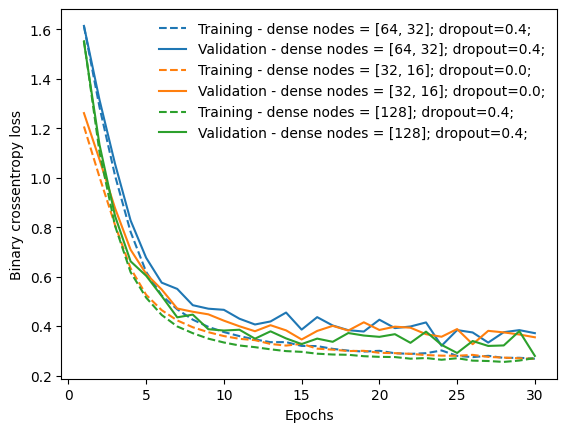

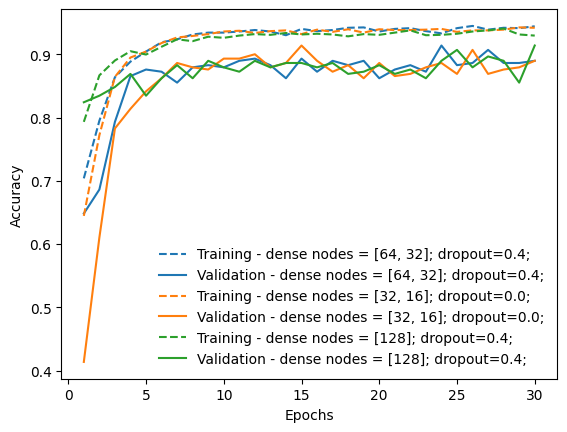

In [19]:
# Plotting loss and accuracy using the function
plot_metrics(df_results, 'loss', 'Binary crossentropy loss', file_dir, 'Loss_Gridsearch.png')
plot_metrics(df_results, 'accuracy', 'Accuracy', file_dir, 'Accuracy_Gridsearch.png')

##Models

From the best results on the hyperparameters obtained with the GridSearchCV, I have manually built 3 models. Each one of them has its accuracy vs epochs and loss vs epochs plotted.

In [20]:
train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
test_hist=HistoryEpoch((X_test, y_test))

In [21]:
# Model 1
learning_rate = 0.001
alpha = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model1 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(32, activation='relu', kernel_regularizer=l2(alpha)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model1.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model1.summary()

history1 = model1.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                     │ (None, 64)                  │          11,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5610 - loss: 1.9331 - val_accuracy: 0.7241 - val_loss: 1.6140 - train_loss: 1.6117 - train_accuracy: 0.7381
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6997 - loss: 1.5135 - val_accuracy: 0.8483 - val_loss: 1.2468 - train_loss: 1.2385 - train_accuracy: 0.8537
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7463 - loss: 1.1997 - val_accuracy: 0.8276 - val_loss: 1.0109 - train_loss: 0.9985 - train_accuracy: 0.8180
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8100 - loss: 0.9457 - val_accuracy: 0.8862 - val_loss: 0.7542 - train_loss: 0.7333 - train_accuracy: 0.9116
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8748 - loss: 0.7596 - val_accuracy: 0.8759 - val_loss: 0.6564 - train_loss: 0.6319 - train_accuracy: 0.8963
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8841 - loss: 0.6444 - val_accuracy: 0.8793 - val_loss: 0.5598 - train_

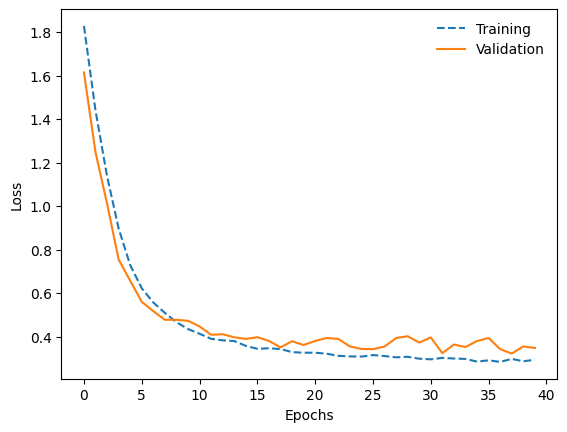

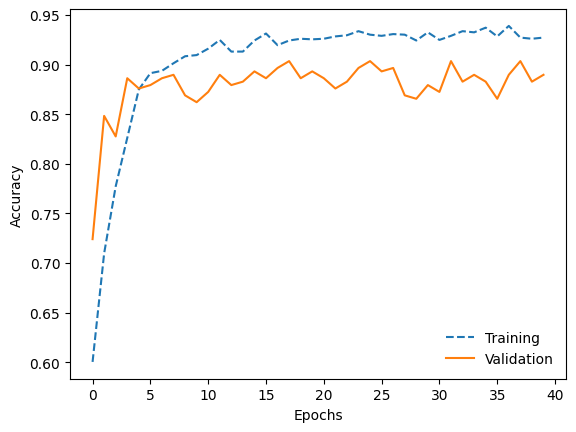

In [22]:
plot_history(history1, '1', file_dir)

In [23]:
# Model 2
learning_rate = 0.001
alpha = 0.01
dropout = 0
optimizer = Adam(learning_rate=learning_rate)

model2 = Sequential([
      Dense(32, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model2.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model2.summary()

history2 = model2.fit(x=X_train, y=y_train, batch_size=64, epochs=30,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                     │ (None, 32)                  │           5,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,761 (22.50 KB)

 Trainable params: 5,761 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6162 - loss: 1.1608 - val_accuracy: 0.7138 - val_loss: 1.0111 - train_loss: 1.0013 - train_accuracy: 0.7721
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7972 - loss: 0.9452 - val_accuracy: 0.8103 - val_loss: 0.8274 - train_loss: 0.8135 - train_accuracy: 0.8622
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8707 - loss: 0.7655 - val_accuracy: 0.8414 - val_loss: 0.6870 - train_loss: 0.6696 - train_accuracy: 0.8810
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8964 - loss: 0.6302 - val_accuracy: 0.8448 - val_loss: 0.5912 - train_loss: 0.5689 - train_accuracy: 0.8912
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8970 - loss: 0.5376 - val_accuracy: 0.8379 - val_loss: 0.5412 - train_loss: 0.5149 - train_accuracy: 0.8895
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9017 - loss: 0.4781 - val_accuracy: 0.8793 - val_loss: 0.4694 - train_

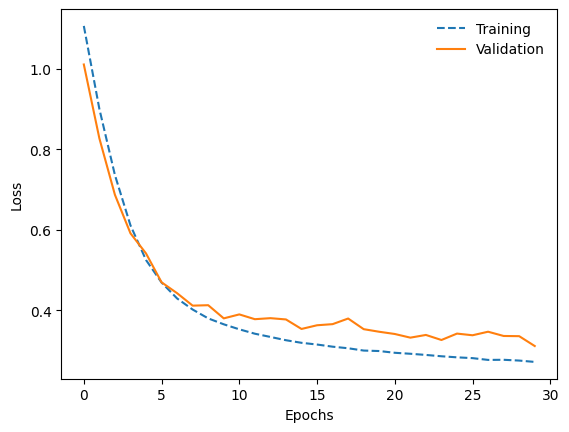

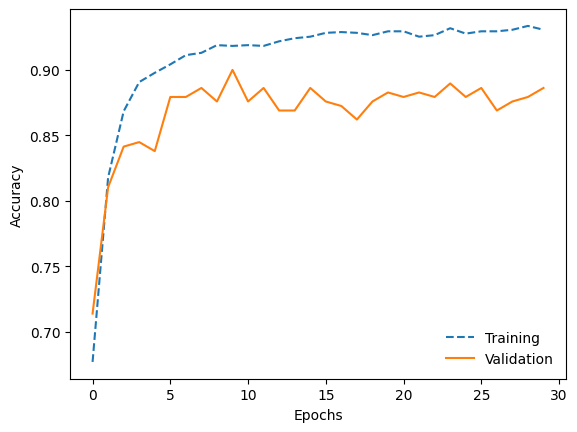

In [24]:
plot_history(history2,'2', file_dir)

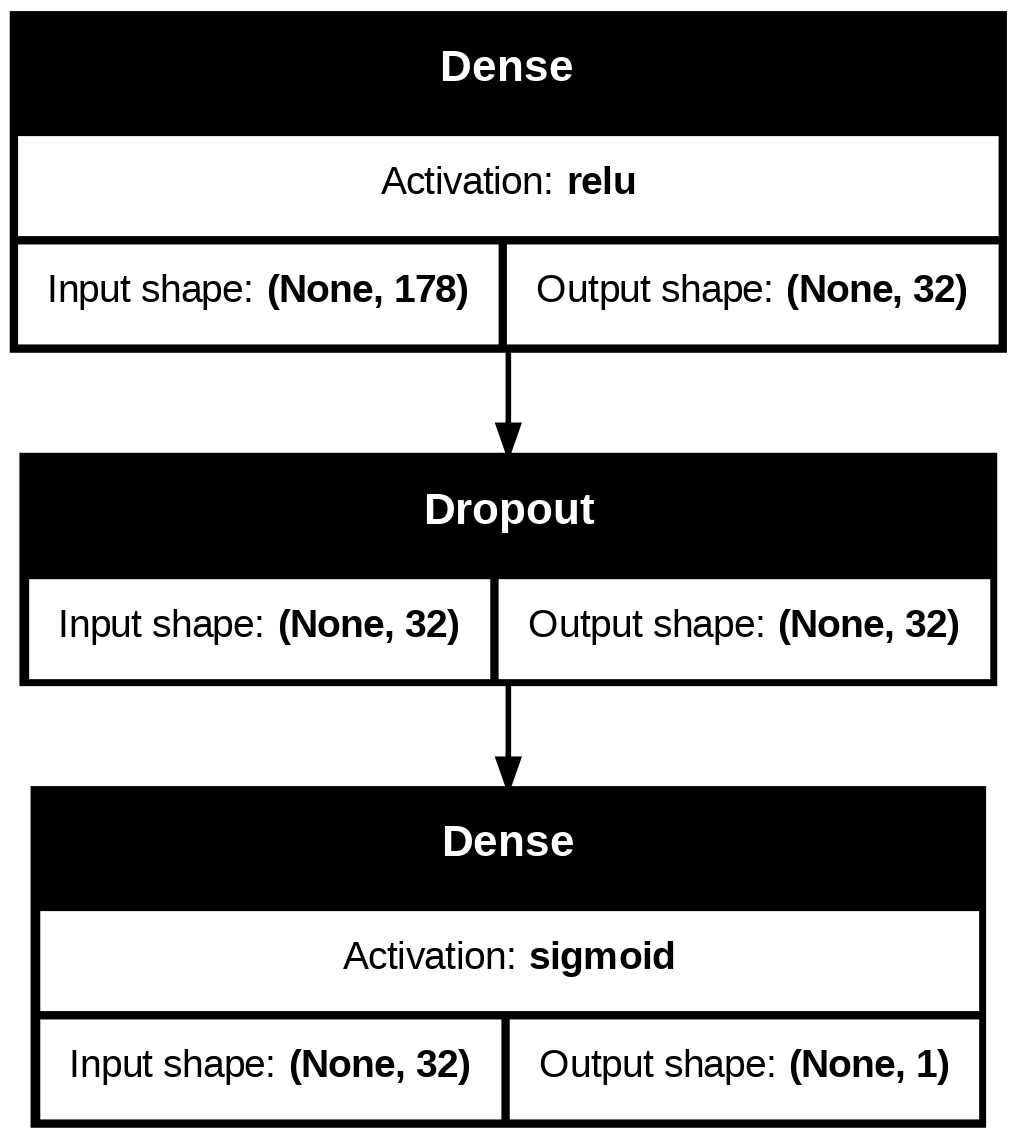

In [25]:
# Display the network architecture for one of the models (Model 2) as an example

plot_model(model2, to_file='model_plot.png', show_shapes=True,
           show_layer_names=False, show_layer_activations=True)
Image('model_plot.png')

In [26]:
# Model 3
learning_rate = 0.001
alpha = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model3 = Sequential([
      Dense(32, activation='relu', kernel_regularizer=l2(alpha),
            input_dim=178),
      Dropout(dropout),
      Dense(16, activation='relu', kernel_regularizer=l2(alpha)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model3.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model3.summary()

history3 = model3.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val))

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                     │ (None, 32)                  │           5,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,273 (24.50 KB)

 Trainable params: 6,273 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5466 - loss: 1.3630 - val_accuracy: 0.7655 - val_loss: 1.1858
Epoch 2/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6186 - loss: 1.1573 - val_accuracy: 0.8241 - val_loss: 1.0054
Epoch 3/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6833 - loss: 0.9968 - val_accuracy: 0.8552 - val_loss: 0.8700
Epoch 4/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7573 - loss: 0.8595 - val_accuracy: 0.8724 - val_loss: 0.7274
Epoch 5/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7879 - loss: 0.7388 - val_accuracy: 0.8690 - val_loss: 0.6309
Epoch 6/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8407 - loss: 0.6259 - val_accuracy: 0.8724 - val_loss: 0.5664
Epoch 7/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - loss: 0.5562 - val_accuracy: 0.8690 - val_loss: 0.5241
Epoch 8/40
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.5157 - val_accuracy: 0.8828 - val_loss

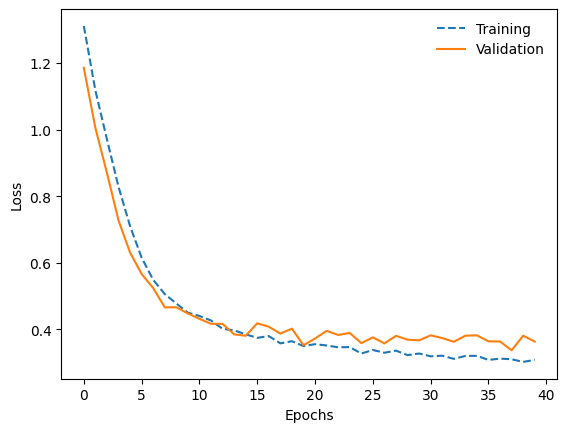

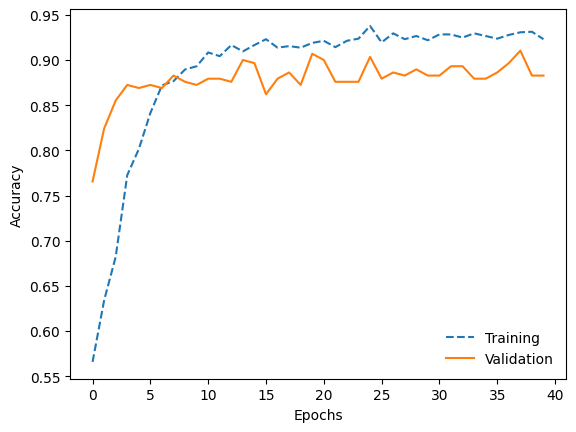

In [27]:
plot_history(history3,'3', file_dir)

##Evaluation



Test Loss: 0.29998189210891724
Test Accuracy: 0.9115646481513977
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Calling classification_report
Classification report generated
Classification Report:
 {'0': {'precision': 0.9780701754385965, 'recall': 0.9139344262295082, 'f1-score': 0.9449152542372881, 'support': 488.0}, '1': {'precision': 0.6818181818181818, 'recall': 0.9, 'f1-score': 0.7758620689655172, 'support': 100.0}, 'accuracy': 0.9115646258503401, 'macro avg': {'precision': 0.8299441786283892, 'recall': 0.9069672131147541, 'f1-score': 0.8603886616014027, 'support': 588.0}, 'weighted avg': {'precision': 0.9276871833262812, 'recall': 0.9115646258503401, 'f1-score': 0.9161647125244019, 'support': 588.0}}
AUC: 0.9667622950819672
Sensitivity: 0.9
Specificity: 0.9139344262295082
Average of performance metrics: 0.921685216397455


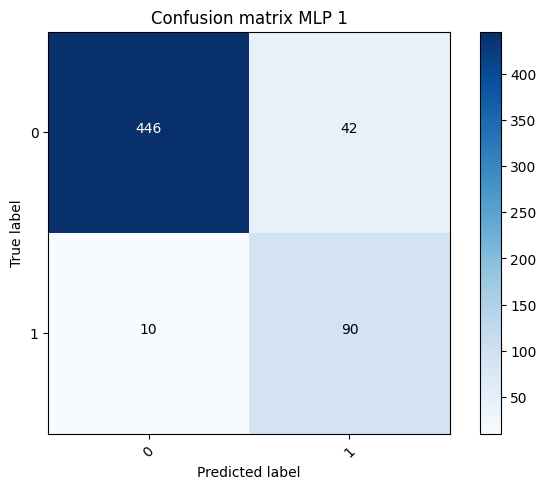

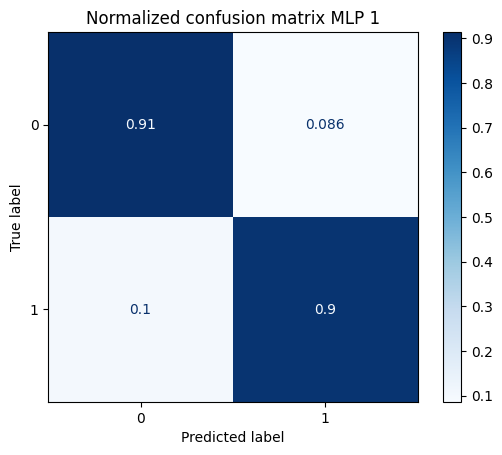

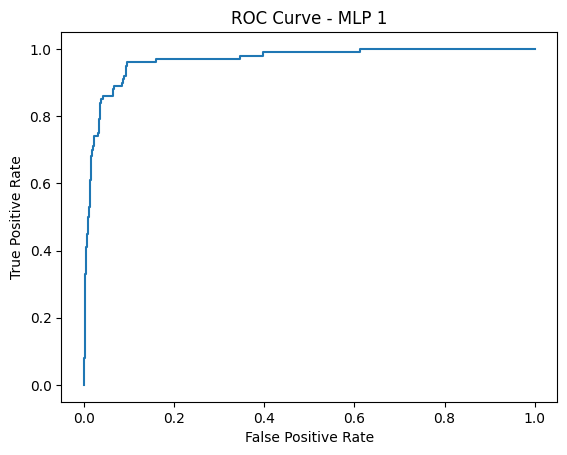

Test Loss: 0.2790379524230957
Test Accuracy: 0.9149659872055054
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Calling classification_report
Classification report generated
Classification Report:
 {'0': {'precision': 0.9781659388646288, 'recall': 0.9180327868852459, 'f1-score': 0.9471458773784355, 'support': 488.0}, '1': {'precision': 0.6923076923076923, 'recall': 0.9, 'f1-score': 0.7826086956521738, 'support': 100.0}, 'accuracy': 0.9149659863945578, 'macro avg': {'precision': 0.8352368155861605, 'recall': 0.909016393442623, 'f1-score': 0.8648772865153047, 'support': 588.0}, 'weighted avg': {'precision': 0.929550590810728, 'recall': 0.9149659863945578, 'f1-score': 0.9191633634794114, 'support': 588.0}}
AUC: 0.9647540983606557
Sensitivity: 0.9
Specificity: 0.9180327868852459
Average of performance metrics: 0.9233832471861637


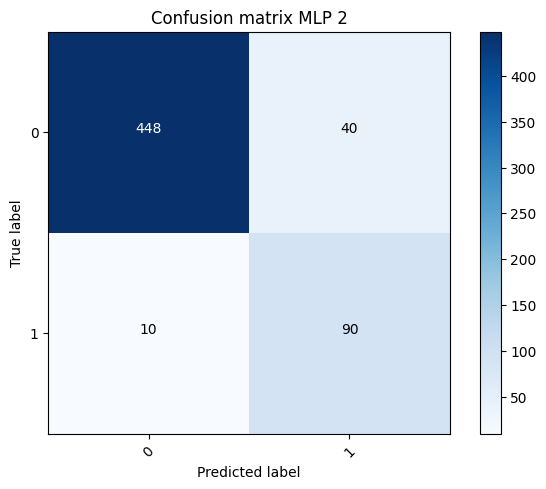

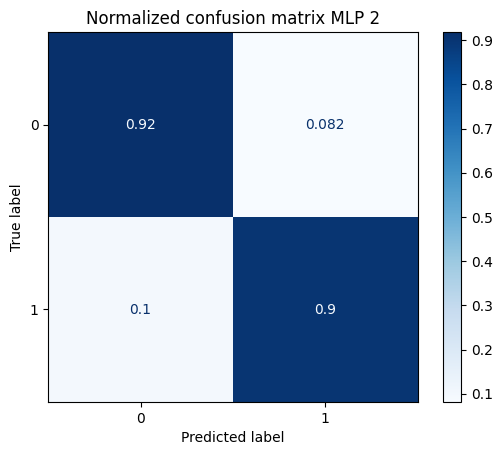

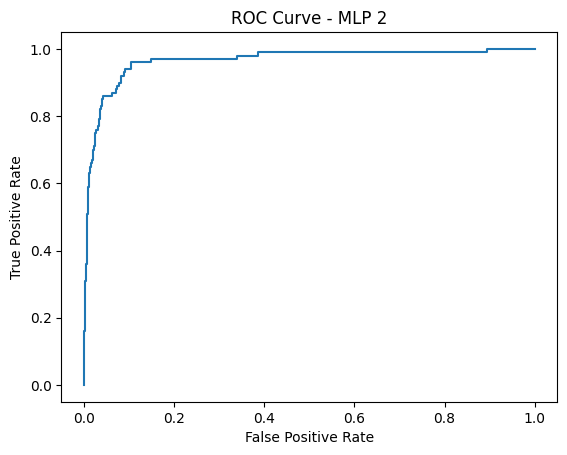

Test Loss: 0.3136999309062958
Test Accuracy: 0.9132652878761292
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Calling classification_report
Classification report generated
Classification Report:
 {'0': {'precision': 0.9802197802197802, 'recall': 0.9139344262295082, 'f1-score': 0.9459172852598091, 'support': 488.0}, '1': {'precision': 0.6842105263157895, 'recall': 0.91, 'f1-score': 0.7811158798283262, 'support': 100.0}, 'accuracy': 0.9132653061224489, 'macro avg': {'precision': 0.8322151532677848, 'recall': 0.911967213114754, 'f1-score': 0.8635165825440676, 'support': 588.0}, 'weighted avg': {'precision': 0.9298780703721626, 'recall': 0.9132653061224489, 'f1-score': 0.9178898353564957, 'support': 588.0}}
AUC: 0.966516393442623
Sensitivity: 0.91
Specificity: 0.9139344262295082
Average of performance metrics: 0.9243211885809511


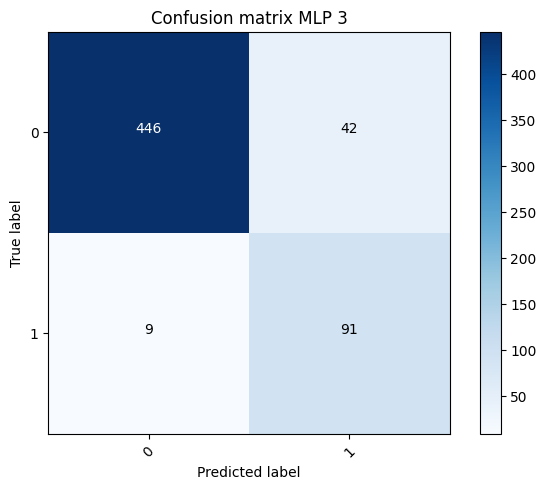

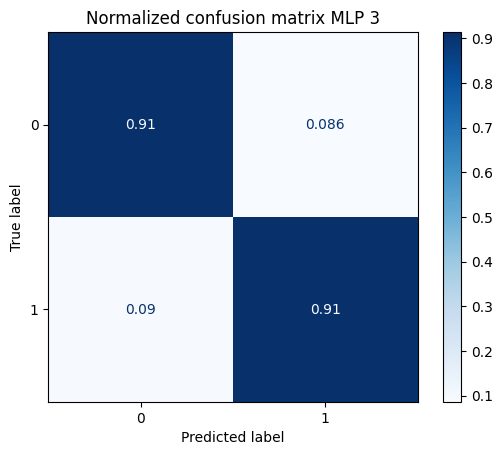

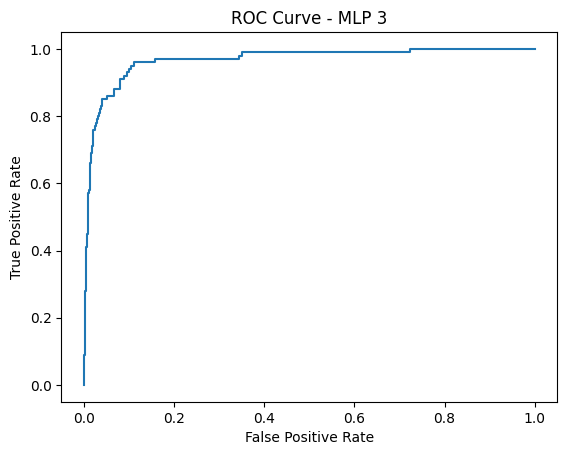

In [28]:
# Evaluate the results of each model

evaluate(X_test, y_test, model1, '1', file_dir)
evaluate(X_test, y_test, model2, '2', file_dir)
evaluate(X_test, y_test, model3, '3', file_dir)

# Method 2: *k*-NN

In k-NN classification, the output is a member of a class. An object is classified as belonging to the class most common among its k nearest neighbors, where k is a positive integer, typically small. In this project, k = 4 was the one with the best results.

In [29]:
X_train_am = X_train
y_train_am = y_train

X_test_am = np.concatenate((X_test,X_val), axis=0)
y_test_am = np.concatenate((y_test,y_val), axis=0)

Accuracy: 0.83
B. Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       728
           1       0.51      0.85      0.64       150

    accuracy                           0.83       878
   macro avg       0.74      0.84      0.76       878
weighted avg       0.89      0.83      0.85       878

AUC: 0.9021336996336995
Sensitivity: 0.8533333333333334
Specificity: 0.8296703296703297
F1-score: 0.8485457022917298
Average of performance metrics: 0.8534792097967525


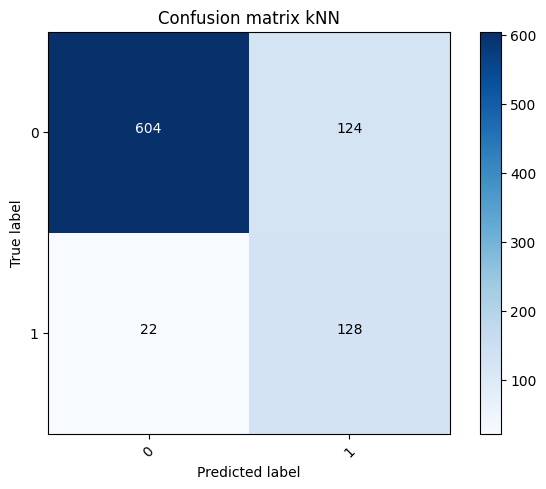

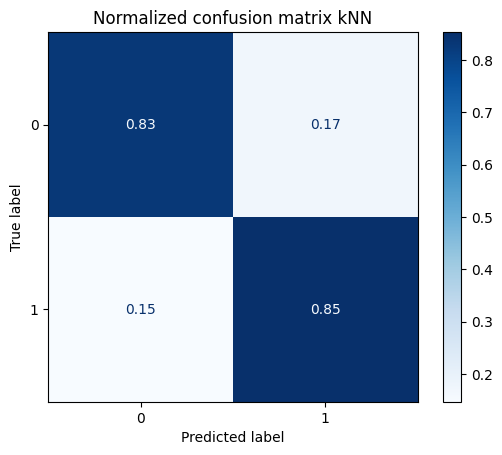

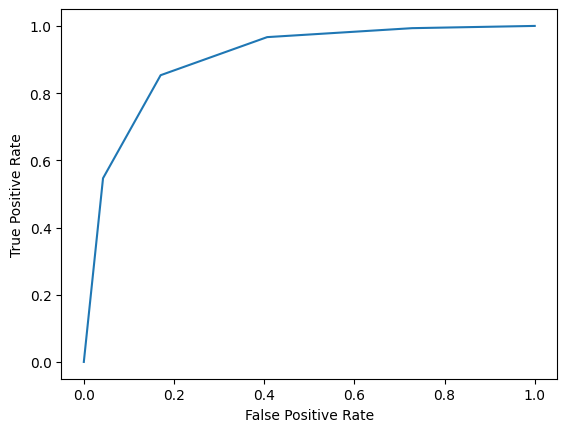

In [30]:
kn = KNeighborsClassifier(n_neighbors=4)

kn.fit(X_train_am, y_train_am)

y_prob_kNN = kn.predict_proba(X_test_am)
y_pred_kNN = kn.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_kNN))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_kNN))
print('Classification Report:\n', classification_report(y_test_am, y_pred_kNN))

cr = classification_report(y_test_am, y_pred_kNN, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_kNN)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_kNN)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr2, tpr2, thresholds2 = roc_curve(y_test_am, y_prob_kNN[:,1])
auc2 = auc(fpr2,tpr2)

print('AUC:', auc2)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc2+f1)/5)

plot_confusion_matrix(file_dir, confusion_mtx, classes = (0,1), method="kNN")

disp = ConfusionMatrixDisplay.from_estimator(kn, X_test_am, y_test_am,
                                             display_labels=(0,1),
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix kNN")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix kNN.png")
plt.show()

plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Method 3: Logistic Regression

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Accuracy: 0.91
B. Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       728
           1       0.66      0.92      0.77       150

    accuracy                           0.91       878
   macro avg       0.82      0.91      0.85       878
weighted avg       0.93      0.91      0.91       878

AUC: 0.9634615384615384
Sensitivity: 0.92
Specificity: 0.9024725274725275
F1-score: 0.9112387812508975
Average of performance metrics: 0.9205279635144414


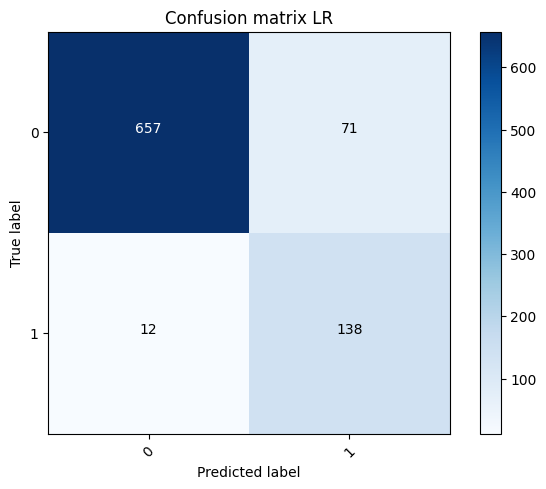

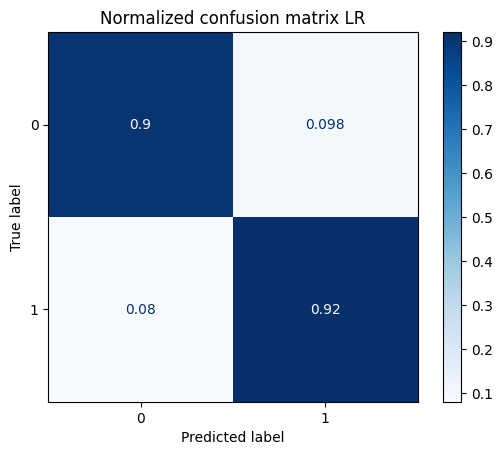

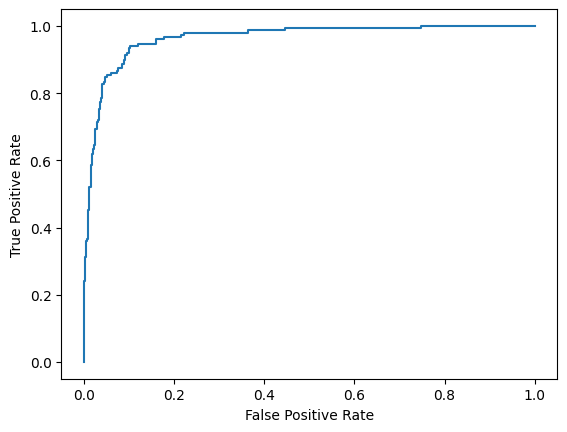

In [31]:
lr = LogisticRegression(solver='lbfgs',
                        multi_class='ovr',
                        penalty='l2',
                        n_jobs=-1,
                        random_state=42)

lr.fit(X_train_am, y_train_am)

y_prob_lr = lr.predict_proba(X_test_am)
y_pred_lr = lr.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_lr))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_lr))
print('Classification Report:\n', classification_report(y_test_am, y_pred_lr))

cr = classification_report(y_test_am, y_pred_lr, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_lr)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_lr)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr3, tpr3, thresholds3 = roc_curve(y_test_am, y_prob_lr[:,1])
auc3 = auc(fpr3,tpr3)

print('AUC:', auc3)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc3+f1)/5)

plot_confusion_matrix(file_dir, confusion_mtx, classes = (0,1), method="LR")

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test_am, y_test_am,
        display_labels=(0,1), cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix LR")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix LR.png")
plt.show()

plt.plot(fpr3,tpr3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#ROC curves comparison


The results are compared using the ROC curves.
The best performances are obtained via the Multi-Layer Perceptron classifier and similar results can be obtained with the Logistic Regression classifier. The k-NN classifier is the worst among the methods analyzed in this work.

In [35]:
def compare_roccurves():
  """
  To compare the different results obtained with the 3 methods.
  """
  plt.figure()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  y_pred_MLP = model3.predict(X_test)
  fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_MLP)

  plt.plot(fpr1,tpr1)
  plt.plot(fpr2,tpr2)
  plt.plot(fpr3,tpr3)

  plt.legend(['MLP','kNN','LR'], frameon=False)
  plt.savefig(f"{file_dir}//HIV-CP Plots/ROC.png")

  plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


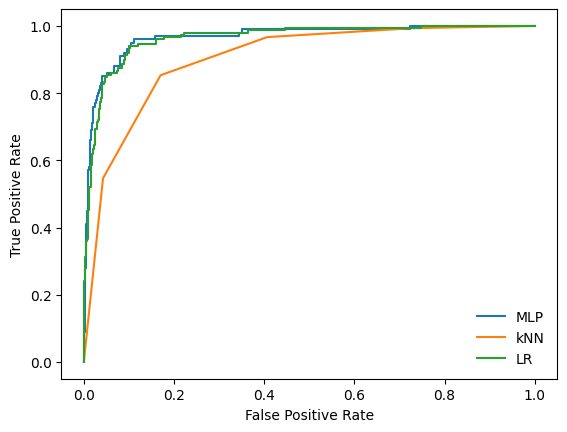

In [36]:
compare_roccurves()